In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights

# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据增强和预处理
train_transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),  # 随机裁剪并调整大小
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(10),  # 随机旋转
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # 随机颜色抖动
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

train_transform_no_aug = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整大小
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

val_transform = transforms.Compose([
    transforms.Resize(256),  # 调整大小
    transforms.CenterCrop(224),  # 中心裁剪
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 加载数据集
train_data_aug = datasets.ImageFolder('a5_data/train', transform=train_transform_aug)
train_data_no_aug = datasets.ImageFolder('a5_data/train', transform=train_transform_no_aug)
val_data = datasets.ImageFolder('a5_data/val', transform=val_transform)

train_loader_aug = DataLoader(train_data_aug, batch_size=32, shuffle=True)
train_loader_no_aug = DataLoader(train_data_no_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)



In [2]:
# 定义模型
class SimpleCNN(nn.Module):
    def __init__(self, use_bn=False, use_residual=False):
        super(SimpleCNN, self).__init__()
        self.use_residual = use_residual
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128) if use_bn else nn.Identity()
        self.fc = None  # 动态计算全连接层输入维度

        # 残差连接的1x1卷积
        if use_residual:
            self.residual_conv = nn.Conv2d(3, 128, kernel_size=1, stride=2)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # 224x224 -> 112x112
        x = self.conv2(x)
        x = self.bn2(x)
        if self.use_residual:
            residual = self.residual_conv(residual)  # 调整残差连接的形状
            x += residual
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # 展平

        # 动态计算全连接层的输入维度
        if self.fc is None:
            self.fc = nn.Linear(x.size(1), 2).to(x.device)
        x = self.fc(x)
        return x



In [3]:
# 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=None):
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # 验证集评估
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # # 保存最佳模型
        # if val_accuracy > best_val_accuracy:
        #     best_val_accuracy = val_accuracy
        #     torch.save(model.state_dict(), 'best_model.pth')
        #     print(f"Saved best model with validation accuracy: {val_accuracy:.4f}")
        
        # 更新学习率
        if scheduler is not None:
            scheduler.step()
    
    return train_losses, val_losses, val_accuracies



In [4]:
# 对比实验
num_epochs = 50
results = {}

# 基线模型（无归一化、无残差连接、无数据增强）
model = SimpleCNN(use_bn=False, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['Baseline'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/50, Train Loss: 0.4574, Val Loss: 0.4815, Val Accuracy: 0.7388
Epoch 2/50, Train Loss: 0.4136, Val Loss: 0.4827, Val Accuracy: 0.7452
Epoch 3/50, Train Loss: 0.4004, Val Loss: 0.4624, Val Accuracy: 0.7620
Epoch 4/50, Train Loss: 0.3928, Val Loss: 0.4551, Val Accuracy: 0.7620
Epoch 5/50, Train Loss: 0.3859, Val Loss: 0.4465, Val Accuracy: 0.7732
Epoch 6/50, Train Loss: 0.3795, Val Loss: 0.4487, Val Accuracy: 0.7668
Epoch 7/50, Train Loss: 0.3753, Val Loss: 0.4507, Val Accuracy: 0.7652
Epoch 8/50, Train Loss: 0.3679, Val Loss: 0.4432, Val Accuracy: 0.7788
Epoch 9/50, Train Loss: 0.3651, Val Loss: 0.4398, Val Accuracy: 0.7748
Epoch 10/50, Train Loss: 0.3615, Val Loss: 0.4413, Val Accuracy: 0.7788
Epoch 11/50, Train Loss: 0.3573, Val Loss: 0.4478, Val Accuracy: 0.7724
Epoch 12/50, Train Loss: 0.3517, Val Loss: 0.4413, Val Accuracy: 0.7780
Epoch 13/50, Train Loss: 0.3489, Val Loss: 0.4295, Val Accuracy: 0.7835
Epoch 14/50, Train Loss: 0.3439, Val Loss: 0.4474, Val Accuracy: 0.7772
E

In [5]:
# 添加批量归一化
model = SimpleCNN(use_bn=True, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With BN'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/50, Train Loss: 0.4162, Val Loss: 0.4371, Val Accuracy: 0.7812
Epoch 2/50, Train Loss: 0.3791, Val Loss: 0.4203, Val Accuracy: 0.7907
Epoch 3/50, Train Loss: 0.3653, Val Loss: 0.4155, Val Accuracy: 0.7923
Epoch 4/50, Train Loss: 0.3476, Val Loss: 0.4178, Val Accuracy: 0.7867
Epoch 5/50, Train Loss: 0.3393, Val Loss: 0.4119, Val Accuracy: 0.7883
Epoch 6/50, Train Loss: 0.3347, Val Loss: 0.4069, Val Accuracy: 0.7995
Epoch 7/50, Train Loss: 0.3246, Val Loss: 0.4087, Val Accuracy: 0.7979
Epoch 8/50, Train Loss: 0.3179, Val Loss: 0.4040, Val Accuracy: 0.8027
Epoch 9/50, Train Loss: 0.3113, Val Loss: 0.4118, Val Accuracy: 0.8027
Epoch 10/50, Train Loss: 0.3029, Val Loss: 0.4095, Val Accuracy: 0.8019
Epoch 11/50, Train Loss: 0.2975, Val Loss: 0.4187, Val Accuracy: 0.8003
Epoch 12/50, Train Loss: 0.2919, Val Loss: 0.4093, Val Accuracy: 0.7971
Epoch 13/50, Train Loss: 0.2874, Val Loss: 0.3952, Val Accuracy: 0.8059
Epoch 14/50, Train Loss: 0.2805, Val Loss: 0.3986, Val Accuracy: 0.8107
E

In [6]:
# 添加残差连接
model = SimpleCNN(use_bn=False, use_residual=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With Residual'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/50, Train Loss: 0.4616, Val Loss: 0.4963, Val Accuracy: 0.7580
Epoch 2/50, Train Loss: 0.4174, Val Loss: 0.4632, Val Accuracy: 0.7684
Epoch 3/50, Train Loss: 0.4025, Val Loss: 0.4507, Val Accuracy: 0.7708
Epoch 4/50, Train Loss: 0.3923, Val Loss: 0.4556, Val Accuracy: 0.7676
Epoch 5/50, Train Loss: 0.3857, Val Loss: 0.4399, Val Accuracy: 0.7819
Epoch 6/50, Train Loss: 0.3780, Val Loss: 0.4346, Val Accuracy: 0.7716
Epoch 7/50, Train Loss: 0.3699, Val Loss: 0.4403, Val Accuracy: 0.7804
Epoch 8/50, Train Loss: 0.3663, Val Loss: 0.4451, Val Accuracy: 0.7684
Epoch 9/50, Train Loss: 0.3590, Val Loss: 0.4313, Val Accuracy: 0.7835
Epoch 10/50, Train Loss: 0.3521, Val Loss: 0.4325, Val Accuracy: 0.7979
Epoch 11/50, Train Loss: 0.3474, Val Loss: 0.4305, Val Accuracy: 0.7867
Epoch 12/50, Train Loss: 0.3427, Val Loss: 0.4366, Val Accuracy: 0.7740
Epoch 13/50, Train Loss: 0.3372, Val Loss: 0.4439, Val Accuracy: 0.7724
Epoch 14/50, Train Loss: 0.3341, Val Loss: 0.4354, Val Accuracy: 0.7979
E

In [7]:
# 添加数据增强
model = SimpleCNN(use_bn=False, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_aug, val_loader, criterion, optimizer, num_epochs)
results['With Data Augmentation'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/50, Train Loss: 0.5295, Val Loss: 0.5031, Val Accuracy: 0.7212
Epoch 2/50, Train Loss: 0.4921, Val Loss: 0.4794, Val Accuracy: 0.7572
Epoch 3/50, Train Loss: 0.4863, Val Loss: 0.4756, Val Accuracy: 0.7548
Epoch 4/50, Train Loss: 0.4706, Val Loss: 0.4723, Val Accuracy: 0.7596
Epoch 5/50, Train Loss: 0.4761, Val Loss: 0.4723, Val Accuracy: 0.7540
Epoch 6/50, Train Loss: 0.4726, Val Loss: 0.4738, Val Accuracy: 0.7532
Epoch 7/50, Train Loss: 0.4623, Val Loss: 0.4670, Val Accuracy: 0.7620
Epoch 8/50, Train Loss: 0.4609, Val Loss: 0.4657, Val Accuracy: 0.7596
Epoch 9/50, Train Loss: 0.4622, Val Loss: 0.4594, Val Accuracy: 0.7612
Epoch 10/50, Train Loss: 0.4577, Val Loss: 0.4684, Val Accuracy: 0.7612
Epoch 11/50, Train Loss: 0.4560, Val Loss: 0.4582, Val Accuracy: 0.7692
Epoch 12/50, Train Loss: 0.4544, Val Loss: 0.4563, Val Accuracy: 0.7676
Epoch 13/50, Train Loss: 0.4558, Val Loss: 0.4645, Val Accuracy: 0.7596
Epoch 14/50, Train Loss: 0.4543, Val Loss: 0.4793, Val Accuracy: 0.7516
E

In [8]:
# 添加迁移学习（使用预训练的 ResNet18）
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With Transfer Learning'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/50, Train Loss: 0.4708, Val Loss: 0.3912, Val Accuracy: 0.8067
Epoch 2/50, Train Loss: 0.3730, Val Loss: 0.3679, Val Accuracy: 0.8291
Epoch 3/50, Train Loss: 0.3509, Val Loss: 0.3853, Val Accuracy: 0.8067
Epoch 4/50, Train Loss: 0.3426, Val Loss: 0.4138, Val Accuracy: 0.7915
Epoch 5/50, Train Loss: 0.3307, Val Loss: 0.3504, Val Accuracy: 0.8347
Epoch 6/50, Train Loss: 0.3322, Val Loss: 0.3550, Val Accuracy: 0.8243
Epoch 7/50, Train Loss: 0.3266, Val Loss: 0.4197, Val Accuracy: 0.7955
Epoch 8/50, Train Loss: 0.3349, Val Loss: 0.3570, Val Accuracy: 0.8299
Epoch 9/50, Train Loss: 0.3279, Val Loss: 0.3980, Val Accuracy: 0.8035
Epoch 10/50, Train Loss: 0.3206, Val Loss: 0.3586, Val Accuracy: 0.8339
Epoch 11/50, Train Loss: 0.3281, Val Loss: 0.3580, Val Accuracy: 0.8243
Epoch 12/50, Train Loss: 0.3143, Val Loss: 0.3611, Val Accuracy: 0.8291
Epoch 13/50, Train Loss: 0.3114, Val Loss: 0.4030, Val Accuracy: 0.8099
Epoch 14/50, Train Loss: 0.3150, Val Loss: 0.3826, Val Accuracy: 0.8147
E

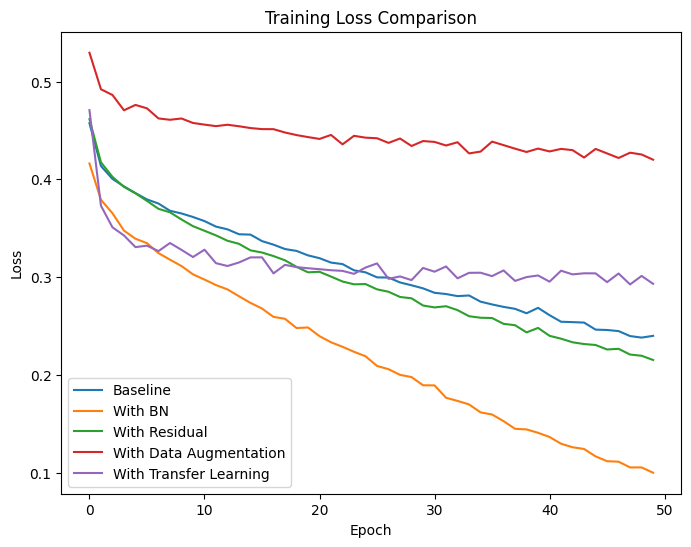

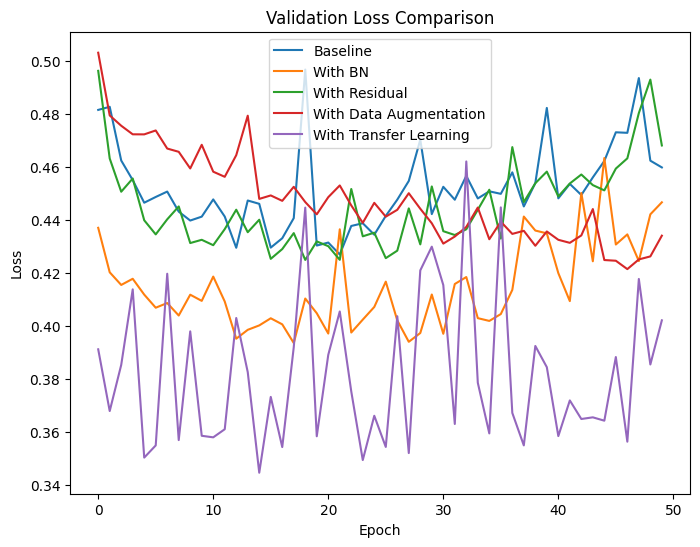

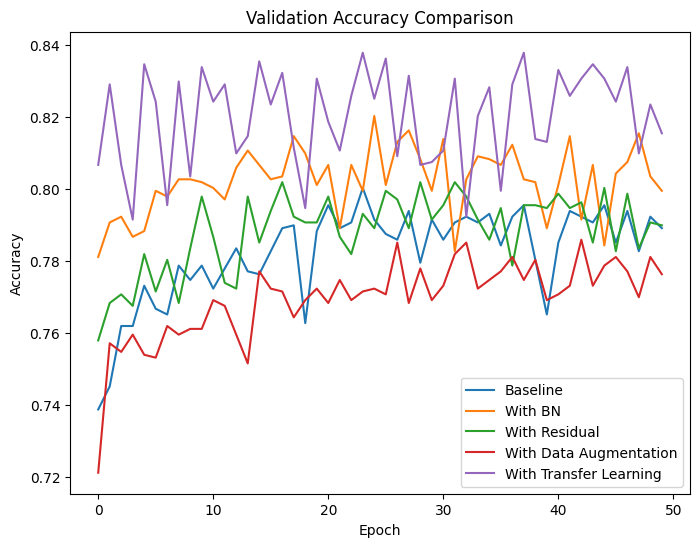

In [9]:
# 绘制训练损失对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['train_loss'], label=label)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制验证损失对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['val_loss'], label=label)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制验证准确率对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['val_accuracy'], label=label)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()